## Assignment #2

* Release date: 2020/05/04
* Due date: **2020/05/10 23:59** (will not accept late submission)
* Submittion format: notebook file which can be executed in Colab environment
* Weighting: 5% (total 50 pts)
* You will build a multi-class classification model using Reuters dataset.

> ### Loading and preprocessing data

In [0]:
from tensorflow.keras.datasets import reuters

# Like IMDB, the argument num_words restricts the data to 
# the 10,000 most frequently occurring words 
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

* Reuters News Classification: 케라스에서 제공하는 로이터 뉴스 기사 데이터
* 로이터 뉴스 기사 데이터는 총 11,258개의 뉴스 기사가 46개의 뉴스 카테고리로 분류 되어 있는 뉴스 기사 데이터이다.


* (10pts) Write the codes for preprocessing data
  * For inputs, the data we have should be converted to binary vectors.
  * For labels, determine an appropriate format by referring to the arguments of model.compile function below.

In [163]:
#preprocessing 을 하기 전에, 데이터를 살펴 봤다.
import numpy as np
num_classes = np.max(train_labels) + 1

print('news for training: {}'.format(len(train_data)))
print('news for testing: {}'.format(len(test_data)))
print('category: {}'.format(num_classes))

news for training: 8982
news for testing: 2246
category: 46


In [164]:
print(train_data[0])
print(train_labels[0])

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
3


In [0]:
# write preprocessing codes
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
  results = np.zeros((len(sequences), dimension))
  for i, sequence in enumerate(sequences):
    results[i, sequence] = 1.
  return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

y_train = np.array(train_labels)
y_test = np.array(test_labels)

* train_labels 중 가장 큰 수에 +1을 하면, 카테고리가 총 몇 개인지 확인할 수 있다.
* vectorize_sequences()를 이용해서 정수 시퀀스를 이진 행렬로 인코딩을 하고 훈련 데이터와 테스트 데이터를 벡터로 변환해준다.
* 또한, 아래에서 sparse_categorical_crossentropy를 사용할 것이므로, 레이블을 one-hot encoding 해주는 것이 아니라 정수형으로 예측하게 하는 인코딩을 해줘야 한다.

> ### Building the network

In [0]:
# Do not modify this block
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

In [0]:
# Do not modify this block
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

> ### Validation

* We employ *k-fold cross validation* as validation method of our model.
* **(15pts)** Write a code in the below to perform *10-fold cross validation*.
* **For each fold, save a model at every epoch in your Google Drive.**

In [168]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [169]:
%cd /content/gdrive

/content/gdrive


In [170]:
%cd 'My Drive'

/content/gdrive/My Drive


In [171]:
# write a code for 10-fold cross validation here
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint

k = 10
num_val_samples = len(train_data) // k
num_epochs = 20
all_acc_histories = []

def build_model(): #훈련되지 않은 새로운 모델 정의
  model = models.Sequential()
  model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(46, activation='softmax'))
  model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  return model

for i in range(k):

  print('processing fold #', i)
  
  val_data = x_train[i*num_val_samples: (i+1)*num_val_samples] #validatioon set 구성
  val_labels = y_train[i*num_val_samples: (i+1)*num_val_samples] #valadation set

  partial_train_data = np.concatenate([x_train[:i*num_val_samples],
                                       x_train[(i+1)*num_val_samples:]],
                                      axis = 0)
  partial_train_labels = np.concatenate([y_train[:i*num_val_samples],
                                          y_train[(i+1)*num_val_samples:]],
                                         axis=0)
  
  filepath = '/content/gdrive/My Drive/exp/model.{epoch:02d}-' + str(i) + '.hdf5'
  modelckpt = ModelCheckpoint(filepath=filepath)

  model = build_model() #모델을 초기화해서 다시 fit 해줌
  history = model.fit(partial_train_data,
                    partial_train_labels,
                    validation_data=(val_data, val_labels),
                    epochs=num_epochs,
                    batch_size=512,
                    verbose=0,
                    callbacks=[modelckpt]) #모델이 fit되는 과정 생략

  results = model.evaluate(x_test, y_test)
  acc_history = history.history['val_accuracy']
  all_acc_histories.append(acc_history)


processing fold # 0
71/71 [==============================] - 0s 2ms/step - loss: 1.1991 - accuracy: 0.7930
processing fold # 1
71/71 [==============================] - 0s 2ms/step - loss: 1.2408 - accuracy: 0.7827
processing fold # 2
71/71 [==============================] - 0s 2ms/step - loss: 1.2238 - accuracy: 0.7921
processing fold # 3
71/71 [==============================] - 0s 2ms/step - loss: 1.1873 - accuracy: 0.7850
processing fold # 4
71/71 [==============================] - 0s 2ms/step - loss: 1.2124 - accuracy: 0.7850
processing fold # 5
71/71 [==============================] - 0s 3ms/step - loss: 1.2438 - accuracy: 0.7778
processing fold # 6
71/71 [==============================] - 0s 2ms/step - loss: 1.1573 - accuracy: 0.7970
processing fold # 7
71/71 [==============================] - 0s 2ms/step - loss: 1.1985 - accuracy: 0.7894
processing fold # 8
71/71 [==============================] - 0s 2ms/step - loss: 1.3201 - accuracy: 0.7734
processing fold # 9
71/71 [==========

* 주어진 데이터를 k 개의 부분으로 나누고, k-1개의 partition으로 테스트를 하고 남은 하나로 validation을 진행한다.
* 해당 코드 실행 결과 위에 정해진 경로('/content/gdrive/My Drive/exp/')에 파일들이 생성된 것을 확인 할 수 있다.

* **(10pts)** Plotting the training and validation accuracy
  * To obtain the validation accuracy at the end of every epoch, just average the performances of all folds.

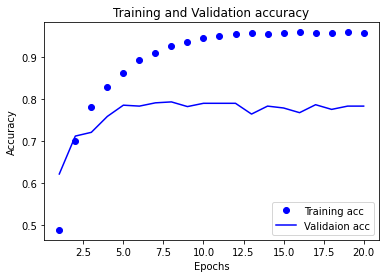

In [172]:
# write a code for plotting the training and validation accuracy
plt.clf()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
all_acc_histories.append(val_acc)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validaion acc')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

* 해당 데이터는 validation에 대해서 overfitting 되어 있다.

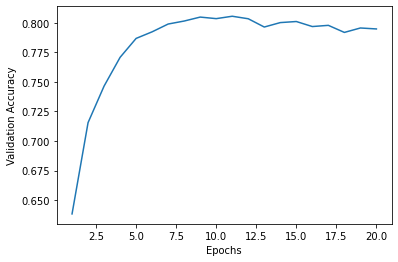

In [173]:
average_acc_history = [np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)]
epochs = range(1, len(average_acc_history) + 1)

plt.clf()
plt.plot(epochs, average_acc_history)
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.show()

* average 를 이용하여 validation accuracy plot 을 생성한다.
* 그래프를 통해서, 10 epoch 근처에서 overfitting 이 이루어 지는 것을 예측할 수 있다.

> ### (15pts) Inference

* Find the best performance model by seeing the performance plot.
* Calculate the accuracy on test set using the best performance model.
  * Here, you should use a majority voting method to get the prediction for a test data point.
  * Specifically, given a test data point, get the predicted class from the trained model on each fold, and then decide the final predicted class by a majority voting.
* **Do not retrain the model.**

* 위의 그래프를 통해 검증 accuracy가 10(번째) epoch 근처에서 overfitting 이 이뤄진다는 것을 예측했다.
* 아래의 과정을 통해 average_acc_history를 직접 출력해보고 실제로 어느 지점 이후 overfitting 이 시작 되는 지 확인한다.

In [176]:
average_acc_history

[0.6383883411234076,
 0.7155294689265165,
 0.7464061596176841,
 0.7707025679675016,
 0.7866977182301608,
 0.7922656265172091,
 0.7988459196957675,
 0.8013767870989713,
 0.804717556996779,
 0.8034014972773466,
 0.8054262128743258,
 0.8033002669161017,
 0.7963150468739596,
 0.800060743635351,
 0.8009718548167836,
 0.7967199737375433,
 0.797732336954637,
 0.7917594638737765,
 0.7955051552165638,
 0.7946952798149802]

In [177]:
m = max(average_acc_history)
print(average_acc_history.index(m))

10


* 10 번째 인덱스의 값이므로, 11 epoch 을 의미한다.

In [194]:
# write a code here
k1=10

for i in range(k1):
  best_model_path = '/content/gdrive/My Drive/exp/model.11-' + str(i) + '.hdf5'
  best_model = models.load_model(best_model_path, custom_objects=None, compile=True)

  results = best_model.evaluate(x_test, y_test)
  print(results)

  predictions = best_model.predict(x_test) #훈련된 모델에서 예측된 클래스를 얻음
  print(np.argmax(predictions[0])) #제일 큰 값을 갖고 있는 index 출력

71/71 [==============================] - 0s 2ms/step - loss: 1.0216 - accuracy: 0.7916
[1.0216282606124878, 0.7916295528411865]
3
71/71 [==============================] - 0s 2ms/step - loss: 1.0038 - accuracy: 0.7956
[1.0038378238677979, 0.7956367135047913]
3
71/71 [==============================] - 0s 2ms/step - loss: 0.9986 - accuracy: 0.7974
[0.99860018491745, 0.7974176406860352]
3
71/71 [==============================] - 0s 2ms/step - loss: 0.9620 - accuracy: 0.7996
[0.9620147347450256, 0.7996438145637512]
3
71/71 [==============================] - 0s 2ms/step - loss: 1.0066 - accuracy: 0.7845
[1.0066310167312622, 0.7845057845115662]
3
71/71 [==============================] - 0s 2ms/step - loss: 1.0042 - accuracy: 0.7939
[1.0041955709457397, 0.7938557267189026]
3
71/71 [==============================] - 0s 2ms/step - loss: 0.9684 - accuracy: 0.8019
[0.968403697013855, 0.8018699884414673]
3
71/71 [==============================] - 0s 3ms/step - loss: 0.9809 - accuracy: 0.7939
[0.980

* np.argmax()를 통해서 제일 큰 값을 갖고 있는 index를 출력한다.
* 10번 중 9번이 3으로 출력 되는 것을 통해서, final predicted class 는 3으로 결정된다.